# Data Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/thesis-folder')

In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sc
import datetime
import calendar

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,  mean_squared_log_error

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
pip install --upgrade category_encoders

     |████████████████████████████████| 80 kB 5.0 MB/s 


In [ ]:
import category_encoders as ce

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install geopy 
!pip install Nominatim

  Created wheel for Nominatim: filename=nominatim-0.1-py3-none-any.whl size=2363 sha256=269235a37e52874ff0aa494089dc2cad8e92107c6b4310c252b91cb60669ae30
  Stored in directory: /root/.cache/pip/wheels/37/00/9e/d904c390bfb174830ad3dcfd62af5544cee7d88bed4f8acedd
Successfully built Nominatim


Read preprocessed master file

In [ ]:
master_df = pd.read_csv('Bureau of transportation/master_file.csv')

In [ ]:
master_df.shape

(3861502, 12)

# Seasonal Predictions

## Spring

In [ ]:
#read spring csv file
spring_df = pd.read_csv('intermittent-result/Domestic US/dom_spring.csv')

In [ ]:
spring_df.drop(columns = 'Unnamed: 0', inplace= True)

Setting date as index

In [ ]:
spring_df.sort_values(['year','month_num'],inplace=True)
spring_df['date'] = pd.to_datetime(spring_df.year.astype(str) + '/' + spring_df.month_num.astype(str) + '/01')

spring_df = spring_df.set_index(['date'])
spring_df.index = pd.to_datetime(spring_df.index)

In [ ]:
#drop unwanted columns
spring_df.drop(columns = ['year','month','month_num'],inplace= True)

In [ ]:
spring_df.head()

,origin_city,dest_city,passengers count
date,,,
2005-03-01,aberdeen,minneapolis,2205.0
2005-03-01,aberdeen,pierre,41.0
2005-03-01,aberdeen,sioux falls,0.0
2005-03-01,abilene,beaumont/port arthur,2.0
2005-03-01,abilene,bullhead city,146.0


In [ ]:
spring_df.shape

(488798, 3)

### Feature Encoding

Binary Encoding

In [ ]:
#encoding origin city information
org_data = spring_df['origin_city']
encoder= ce.BinaryEncoder(cols=['origin_city'],return_df=True)
print(encoder)
data_encoded=encoder.fit_transform(org_data) 
data_encoded

BinaryEncoder(cols=['origin_city'], drop_invariant=False,
              handle_missing='value', handle_unknown='value', mapping=None,
              return_df=True, verbose=0)


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,origin_city_0,origin_city_1,origin_city_2,origin_city_3,origin_city_4,origin_city_5,origin_city_6,origin_city_7,origin_city_8,origin_city_9,origin_city_10,origin_city_11
date,,,,,,,,,,,,
2005-03-01,0,0,0,0,0,0,0,0,0,0,0,1
2005-03-01,0,0,0,0,0,0,0,0,0,0,0,1
2005-03-01,0,0,0,0,0,0,0,0,0,0,0,1
2005-03-01,0,0,0,0,0,0,0,0,0,0,1,0
2005-03-01,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-01,0,0,1,1,0,0,0,0,0,1,0,0
2019-05-01,0,0,1,1,0,0,0,0,0,1,0,0
2019-05-01,0,0,1,1,0,0,0,0,0,1,0,0


In [ ]:
#encoding destination city information
dest_data = spring_df['dest_city']
encoder1= ce.BinaryEncoder(cols=['dest_city'],return_df=True)
print(encoder1)
data_encoded1=encoder1.fit_transform(dest_data) 
data_encoded1

BinaryEncoder(cols=['dest_city'], drop_invariant=False, handle_missing='value',
              handle_unknown='value', mapping=None, return_df=True, verbose=0)


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,dest_city_0,dest_city_1,dest_city_2,dest_city_3,dest_city_4,dest_city_5,dest_city_6,dest_city_7,dest_city_8,dest_city_9,dest_city_10,dest_city_11
date,,,,,,,,,,,,
2005-03-01,0,0,0,0,0,0,0,0,0,0,0,1
2005-03-01,0,0,0,0,0,0,0,0,0,0,1,0
2005-03-01,0,0,0,0,0,0,0,0,0,0,1,1
2005-03-01,0,0,0,0,0,0,0,0,0,1,0,0
2005-03-01,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-01,0,0,0,0,0,0,0,0,0,1,1,0
2019-05-01,0,0,0,0,0,0,1,0,0,1,0,1
2019-05-01,0,1,0,0,1,1,1,0,0,0,0,0


In [ ]:
#concat the above two dataframes
df = pd.concat([data_encoded, data_encoded1], axis=1)
spring_df = pd.concat([spring_df, df], axis=1)
spring_df

,origin_city,dest_city,passengers count,origin_city_0,origin_city_1,origin_city_2,origin_city_3,origin_city_4,origin_city_5,origin_city_6,origin_city_7,origin_city_8,origin_city_9,origin_city_10,origin_city_11,dest_city_0,dest_city_1,dest_city_2,dest_city_3,dest_city_4,dest_city_5,dest_city_6,dest_city_7,dest_city_8,dest_city_9,dest_city_10,dest_city_11
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-03-01,aberdeen,minneapolis,2205.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2005-03-01,aberdeen,pierre,41.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2005-03-01,aberdeen,sioux falls,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
2005-03-01,abilene,beaumont/port arthur,2.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2005-03-01,abilene,bullhead city,146.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-01,yuma,dallas/fort worth,1641.0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2019-05-01,yuma,detroit,0.0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1
2019-05-01,yuma,gastonia,387.0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,1,0,0,0,0,0


### LSTM

In [ ]:
#function for initialising the data
def initialise_data(X_train, X_val, X_test, y_train, y_val, y_test):
  scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
  X_train_scaled = scaler.fit_transform(X_train)
  X_val_scaled = scaler.transform(X_val)
  X_test_scaled = scaler.transform(X_test)

  y_train_scaled = scaler.fit_transform(y_train)
  y_val_scaled = scaler.transform(y_val)
  y_test_scaled = scaler.transform(y_test)

  batch_size = 64

  train_attribute = torch.Tensor(X_train_scaled)
  train_output = torch.Tensor(y_train_scaled)
  val_attribute = torch.Tensor(X_val_scaled)
  val_output = torch.Tensor(y_val_scaled)
  test_attribute = torch.Tensor(X_test_scaled)
  test_output = torch.Tensor(y_test_scaled)

  train = TensorDataset(train_attribute, train_output)
  val = TensorDataset(val_attribute, val_output)
  test = TensorDataset(test_attribute, test_output)

  master_train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
  master_val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
  master_test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
  master_test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

  return master_train_loader, master_val_loader, master_test_loader, master_test_loader_one, scaler

In [ ]:
#class to initialise the LSTM parameters 
class Lstm_forecast(nn.Module):
    
    def __init__(self, input, hidden, layer, output, dropout):
        
        super(Lstm_forecast, self).__init__()
        self.hidden = hidden
        self.layer = layer
        self.lstm = nn.LSTM(
            input, hidden, layer, batch_first=True, dropout=dropout
        )

        self.fc = nn.Linear(hidden, output)

    def forward(self, x):
        h0 = torch.zeros(self.layer, x.size(0), self.hidden).requires_grad_()
        c0 = torch.zeros(self.layer, x.size(0), self.hidden).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [ ]:
#function for returning the LSTM model
def get_lstm_model(model, model_parameters):
    models = {
        "lstm": Lstm_forecast
    }
    return models.get(model.lower())(**model_parameters)

In [ ]:
#class for optimising and capturing loss details
class Opt_model:
    
    def __init__(self, model, loss_function, optimizer):
        
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def step_optimizer(self, x, y):
       
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        ydash = self.model(x)

        # Computes loss
        loss = self.loss_function(y, ydash)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, master_train_loader, master_val_loader, batch_size=64, n_epochs=50, n_features=1):
      
        #model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in master_train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.step_optimizer(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                val_loss_list = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    ydash = self.model(x_val)
                    val_loss = self.loss_function(y_val, ydash).item()
                    val_loss_list.append(val_loss)
                validation_loss = np.mean(val_loss_list)
                self.val_losses.append(validation_loss)

            print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}")

        #torch.save(self.model.state_dict(), model_path)

    def evaluate(self, master_test_loader, batch_size=1, n_features=1):
       
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in master_test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                ydash = self.model(x_test)
                predictions.append(ydash.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values

    def plot_losses(self):
        
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [ ]:
#function for getting the shape of the input data
def get_input_shape(X_train):
  input = len(X_train.columns)
  
  return input

In [ ]:
#functions for calculating the error metrics
def adjusted_r2_score(df,score, test_data):
  n=len(df) #number of records
  p=test_data.shape[1] #number of features .i.e. columns excluding uniqueId and target variable
  adjusted_r2 = 1-(1-score)*(n-1)/(n-p-1)
  return adjusted_r2

def get_score(df, test_data):
    scores = {'mae' : mean_absolute_error(df.value, df.prediction),
                      'r2' : r2_score(df.value, df.prediction),
                      'adjusted r2 score' : adjusted_r2_score(df, r2_score(df.value, df.prediction), test_data) }
    
    print("Mean Absolute Error:       ", scores["mae"])
    print("R^2 Score:                 ", scores["r2"])
    print("Adjusted R^2 score         ", scores["adjusted r2 score"])
    return scores

In [ ]:
#functions for inverse transforming the data and storing the predictions
def transform_data(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def create_results(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals.round(4), "prediction": preds.round(4)}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = transform_data(scaler, df_result, [["value", "prediction"]])
    return df_result

[1/50] Training loss: 0.0042	 Validation loss: 0.0039
[2/50] Training loss: 0.0041	 Validation loss: 0.0039
[3/50] Training loss: 0.0040	 Validation loss: 0.0038
[4/50] Training loss: 0.0040	 Validation loss: 0.0037
[5/50] Training loss: 0.0039	 Validation loss: 0.0036
[6/50] Training loss: 0.0037	 Validation loss: 0.0034
[7/50] Training loss: 0.0037	 Validation loss: 0.0034
[8/50] Training loss: 0.0036	 Validation loss: 0.0034
[9/50] Training loss: 0.0036	 Validation loss: 0.0034
[10/50] Training loss: 0.0035	 Validation loss: 0.0033
[11/50] Training loss: 0.0034	 Validation loss: 0.0033
[12/50] Training loss: 0.0034	 Validation loss: 0.0032
[13/50] Training loss: 0.0033	 Validation loss: 0.0032
[14/50] Training loss: 0.0033	 Validation loss: 0.0032
[15/50] Training loss: 0.0032	 Validation loss: 0.0032
[16/50] Training loss: 0.0031	 Validation loss: 0.0031
[17/50] Training loss: 0.0031	 Validation loss: 0.0029
[18/50] Training loss: 0.0031	 Validation loss: 0.0029
[19/50] Training lo

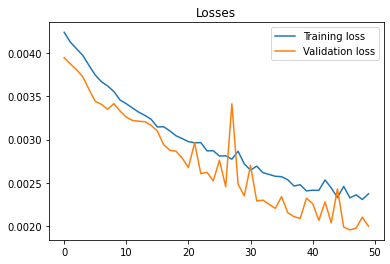

Mean Absolute Error:        4069.0857
R^2 Score:                  0.5372294296543866
Adjusted R^2 score          0.5371157896346566
                  value   prediction
date                                
2007-05-01     0.000000   523.090393
2007-05-01  5548.494629  2353.906738
2007-05-01     0.000000   261.545197
2007-05-01   336.272400   784.635559
2007-05-01    18.681799  -354.954193
...                 ...          ...
2010-05-01    56.045403  -280.226990
2010-05-01    56.045403  1998.952637
2010-05-01    18.681799   859.362793
2010-05-01    18.681799  1438.498535
2010-05-01    93.409004  3474.814697

[97759 rows x 2 columns]
MAE scores [4069.0857]
R2 scores [0.5372294296543866]
ADJ R2 scores [0.5371157896346566]
[1/50] Training loss: 0.0041	 Validation loss: 0.0037
[2/50] Training loss: 0.0039	 Validation loss: 0.0035
[3/50] Training loss: 0.0038	 Validation loss: 0.0033
[4/50] Training loss: 0.0036	 Validation loss: 0.0032
[5/50] Training loss: 0.0035	 Validation loss: 0.0031
[6

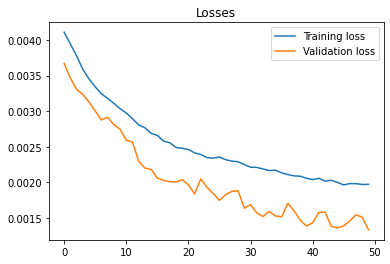

Mean Absolute Error:        3949.0034
R^2 Score:                  0.6535016671218878
Adjusted R^2 score          0.6534165794350125
                  value    prediction
date                                 
2010-05-01    56.045403   2054.998047
2010-05-01  3773.723389  10013.444336
2010-05-01     0.000000   1457.180420
2010-05-01    18.681799   2764.906494
2010-05-01  6968.311523  14665.213867
...                 ...           ...
2013-05-01   205.499802   1326.407837
2013-05-01    18.681799    635.181213
2013-05-01    18.681799   1046.180786
2013-05-01     0.000000    784.635559
2013-05-01  3157.224121   5342.994629

[97759 rows x 2 columns]
MAE scores [4069.0857, 3949.0034]
R2 scores [0.5372294296543866, 0.6535016671218878]
ADJ R2 scores [0.5371157896346566, 0.6534165794350125]
[1/50] Training loss: 0.0039	 Validation loss: 0.0042
[2/50] Training loss: 0.0037	 Validation loss: 0.0037
[3/50] Training loss: 0.0034	 Validation loss: 0.0034
[4/50] Training loss: 0.0033	 Validation loss:

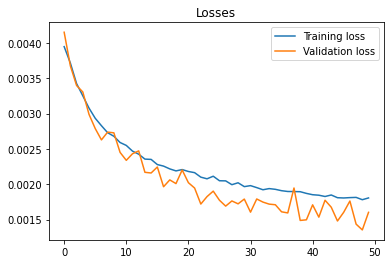

Mean Absolute Error:        4031.4814
R^2 Score:                  0.6228143948188978
Adjusted R^2 score          0.6227217714276077
                  value   prediction
date                                
2013-05-01     0.000000  2223.134277
2013-05-01  9023.309570  4558.358887
2013-05-01  2858.315430  4801.222656
2013-05-01     0.000000    37.363598
2013-05-01     0.000000  1214.317017
...                 ...          ...
2016-05-01  7360.629395  5791.357910
2016-05-01  3269.314941   205.499802
2016-05-01  8145.264648  4240.768555
2016-05-01    74.727196  2017.634399
2016-05-01  6706.766113  4053.950684

[97759 rows x 2 columns]
MAE scores [4069.0857, 3949.0034, 4031.4814]
R2 scores [0.5372294296543866, 0.6535016671218878, 0.6228143948188978]
ADJ R2 scores [0.5371157896346566, 0.6534165794350125, 0.6227217714276077]
[1/50] Training loss: 0.0040	 Validation loss: 0.0054
[2/50] Training loss: 0.0037	 Validation loss: 0.0043
[3/50] Training loss: 0.0034	 Validation loss: 0.0041
[4/50] T

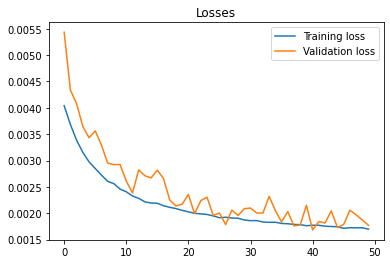

Mean Absolute Error:        4450.7505
R^2 Score:                  0.6207211676110226
Adjusted R^2 score          0.6206280301974578
                   value    prediction
date                                  
2016-05-01  26995.201172   7360.629395
2016-05-01   3045.133545   8574.946289
2016-05-01  68450.117188  28919.425781
2016-05-01      0.000000  10928.852539
2016-05-01   3829.769043   5417.721680
...                  ...           ...
2019-05-01   1643.998413   6669.402832
2019-05-01      0.000000   2690.179199
2019-05-01    392.317780    990.135376
2019-05-01      0.000000   1064.862671
2019-05-01   7715.583008   3287.996826

[97759 rows x 2 columns]
MAE scores [4069.0857, 3949.0034, 4031.4814, 4450.7505]
R2 scores [0.5372294296543866, 0.6535016671218878, 0.6228143948188978, 0.6207211676110226]
ADJ R2 scores [0.5371157896346566, 0.6534165794350125, 0.6227217714276077, 0.6206280301974578]
Min MAE score 3949.00341796875
Max R2 score 0.6535016671218878
Max adjusted R2 score 0.653416

In [ ]:
test_data_ratio = 0.2

#cross validation call
tscv_split = TimeSeriesSplit(max_train_size=None, n_splits= 4)

X = spring_df.drop(columns=['passengers count','origin_city','dest_city'])
y = spring_df[['passengers count']]
val_ratio = test_data_ratio / (1 - test_data_ratio)


output = 1
hidden = 64
layer = 3
batch_size = 64
dropout = 0.2
n_epochs = 50
learning_rate = 1e-3
weight_decay = 1e-6

mae_list = []
r2_score_list = []
adj_r2_score_list = []

for train_index_value, test_index_value in tscv_split.split(X):
  #print("TRAIN:", train_index_value, "TEST:", test_index_value) 
  X_train, X_test = X.iloc[train_index_value], X.iloc[test_index_value]
  y_train, y_test = y.iloc[train_index_value], y.iloc[test_index_value]
  val_ratio = test_data_ratio / (1 - test_data_ratio)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
  #print("X_train",X_train,"x_val",X_val)
  master_train_loader, master_val_loader, master_test_loader, master_test_loader_one, scaler = initialise_data(X_train, X_val, X_test, y_train, y_val,y_test)

  input = get_input_shape(X_train)
  model_parameters = {'input': input,
                'hidden' : hidden,
                'layer' : layer,
                'output' : output,
                'dropout' : dropout}

  spring_model = get_lstm_model('lstm', model_parameters)
  loss_function = nn.MSELoss(reduction="mean")
  optimizer = optim.Adam(spring_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  opt = Opt_model(model=spring_model, loss_function=loss_function, optimizer=optimizer)

  opt.train(master_train_loader, master_val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input)
  opt.plot_losses()

  predictions, values = opt.evaluate(
      master_test_loader_one,
      batch_size=1,
      n_features=input
  )

  df_result = create_results(predictions, values, X_test, scaler)
  #predictions_df = pd.concat([predictions_df, df_result], axis=0)
  scores = get_score(df_result, X_test)  
  print(df_result)
  
  mae_list.append(scores.get('mae'))
  r2_score_list.append(scores.get('r2'))
  adj_r2_score_list.append(scores.get('adjusted r2 score'))
  print('MAE scores' , mae_list)
  print('R2 scores' , r2_score_list)
  print('ADJ R2 scores' ,adj_r2_score_list)
  
mae_min = min(mae_list)
max_r2_score = max(r2_score_list)
max_adj_r2 = max(adj_r2_score_list)

print("Min MAE score {}".format(mae_min))
print("Max R2 score {}".format(max_r2_score))
print("Max adjusted R2 score {}".format(max_adj_r2))



In [ ]:
#storing the train and test results for visualisation
train_set = pd.concat([y_train, y_val], axis=0)
train_set.to_csv('results/dspring_4splits_train.csv')
df_result.to_csv('results/dspring_4splits_test.csv')
df_grouped_result = df_result.groupby('date').sum()
train_grouped_set = train_set.groupby('date').sum()


## Summer

In [ ]:
summer_df = pd.read_csv('intermittent-result/Domestic US/dom_summer.csv')

In [ ]:
summer_df.drop(columns = 'Unnamed: 0', inplace= True)

In [ ]:
summer_df.sort_values(['year','month_num'],inplace=True)
summer_df['date'] = pd.to_datetime(summer_df.year.astype(str) + '/' + summer_df.month_num.astype(str) + '/01')

summer_df = summer_df.set_index(['date'])
summer_df.index = pd.to_datetime(summer_df.index)

In [ ]:
summer_df.drop(columns = ['year','month','month_num'],inplace= True)

In [ ]:
summer_df.head()

,origin_city,dest_city,passengers count
date,,,
2005-06-01,aberdeen,minneapolis,2537.0
2005-06-01,aberdeen,pierre,50.0
2005-06-01,aberdeen,sioux falls,0.0
2005-06-01,abilene,bullhead city,137.0
2005-06-01,abilene,dallas/fort worth,5533.0


In [ ]:
summer_df.shape

(501723, 3)

### Feature Encoding

In [ ]:
#encoding origin city
org_data = summer_df['origin_city']
encoder= ce.BinaryEncoder(cols=['origin_city'],return_df=True)
print(encoder)
data_encoded=encoder.fit_transform(org_data) 
data_encoded

BinaryEncoder(cols=['origin_city'], drop_invariant=False,
              handle_missing='value', handle_unknown='value', mapping=None,
              return_df=True, verbose=0)


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,origin_city_0,origin_city_1,origin_city_2,origin_city_3,origin_city_4,origin_city_5,origin_city_6,origin_city_7,origin_city_8,origin_city_9,origin_city_10,origin_city_11
date,,,,,,,,,,,,
2005-06-01,0,0,0,0,0,0,0,0,0,0,0,1
2005-06-01,0,0,0,0,0,0,0,0,0,0,0,1
2005-06-01,0,0,0,0,0,0,0,0,0,0,0,1
2005-06-01,0,0,0,0,0,0,0,0,0,0,1,0
2005-06-01,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,0,0,1,1,0,0,0,1,0,0,1,0
2019-08-01,0,0,1,1,0,0,0,1,0,0,1,0
2019-08-01,0,0,1,1,0,0,0,1,0,1,0,0


In [ ]:
#encoding destination city
dest_data = summer_df['dest_city']
encoder1= ce.BinaryEncoder(cols=['dest_city'],return_df=True)
print(encoder1)
data_encoded1=encoder1.fit_transform(dest_data) 
data_encoded1

BinaryEncoder(cols=['dest_city'], drop_invariant=False, handle_missing='value',
              handle_unknown='value', mapping=None, return_df=True, verbose=0)


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,dest_city_0,dest_city_1,dest_city_2,dest_city_3,dest_city_4,dest_city_5,dest_city_6,dest_city_7,dest_city_8,dest_city_9,dest_city_10,dest_city_11
date,,,,,,,,,,,,
2005-06-01,0,0,0,0,0,0,0,0,0,0,0,1
2005-06-01,0,0,0,0,0,0,0,0,0,0,1,0
2005-06-01,0,0,0,0,0,0,0,0,0,0,1,1
2005-06-01,0,0,0,0,0,0,0,0,0,1,0,0
2005-06-01,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,0,0,0,0,1,1,0,1,0,0,0,1
2019-08-01,0,0,0,0,0,1,0,1,1,0,1,1
2019-08-01,0,0,0,1,0,0,1,1,1,0,1,0


In [ ]:
#combining the above two dfs
df = pd.concat([data_encoded, data_encoded1], axis=1)
summer_df = pd.concat([summer_df, df], axis=1)
summer_df

,origin_city,dest_city,passengers count,origin_city_0,origin_city_1,origin_city_2,origin_city_3,origin_city_4,origin_city_5,origin_city_6,origin_city_7,origin_city_8,origin_city_9,origin_city_10,origin_city_11,dest_city_0,dest_city_1,dest_city_2,dest_city_3,dest_city_4,dest_city_5,dest_city_6,dest_city_7,dest_city_8,dest_city_9,dest_city_10,dest_city_11
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-06-01,aberdeen,minneapolis,2537.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2005-06-01,aberdeen,pierre,50.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2005-06-01,aberdeen,sioux falls,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
2005-06-01,abilene,bullhead city,137.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2005-06-01,abilene,dallas/fort worth,5533.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,yakutat,ketchikan,9.0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,1
2019-08-01,yakutat,seattle,752.0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,1
2019-08-01,youngstown/warren,montgomery,153.0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,1,0,1,0


### LSTM

[1/50] Training loss: 0.0052	 Validation loss: 0.0057
[2/50] Training loss: 0.0051	 Validation loss: 0.0053
[3/50] Training loss: 0.0050	 Validation loss: 0.0052
[4/50] Training loss: 0.0049	 Validation loss: 0.0050
[5/50] Training loss: 0.0047	 Validation loss: 0.0048
[6/50] Training loss: 0.0046	 Validation loss: 0.0046
[7/50] Training loss: 0.0044	 Validation loss: 0.0043
[8/50] Training loss: 0.0042	 Validation loss: 0.0041
[9/50] Training loss: 0.0041	 Validation loss: 0.0040
[10/50] Training loss: 0.0040	 Validation loss: 0.0039
[11/50] Training loss: 0.0040	 Validation loss: 0.0039
[12/50] Training loss: 0.0039	 Validation loss: 0.0038
[13/50] Training loss: 0.0038	 Validation loss: 0.0037
[14/50] Training loss: 0.0038	 Validation loss: 0.0037
[15/50] Training loss: 0.0037	 Validation loss: 0.0037
[16/50] Training loss: 0.0037	 Validation loss: 0.0037
[17/50] Training loss: 0.0036	 Validation loss: 0.0037
[18/50] Training loss: 0.0036	 Validation loss: 0.0036
[19/50] Training lo

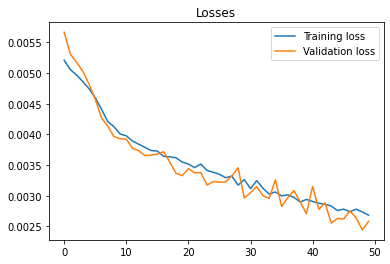

Mean Absolute Error:        4597.772
R^2 Score:                  0.5149244367673464
Adjusted R^2 score          0.5148083888251063
                    value    prediction
date                                   
2007-08-01       0.000000   -840.379395
2007-08-01     205.807205   -600.270996
2007-08-01       0.000000  -1251.993774
2007-08-01       0.000000  -1251.993774
2007-08-01      17.150600   -926.132446
...                   ...           ...
2010-08-01   14818.119141  32483.236328
2010-08-01   42962.250000   3755.981445
2010-08-01   15264.034180  22244.328125
2010-08-01  108100.226562  84844.023438
2010-08-01       0.000000   2315.331055

[100344 rows x 2 columns]
MAE scores [4597.772]
R2 scores [0.5149244367673464]
ADJ R2 scores [0.5148083888251063]
[1/50] Training loss: 0.0051	 Validation loss: 0.0047
[2/50] Training loss: 0.0049	 Validation loss: 0.0046
[3/50] Training loss: 0.0047	 Validation loss: 0.0043
[4/50] Training loss: 0.0044	 Validation loss: 0.0039
[5/50] Training lo

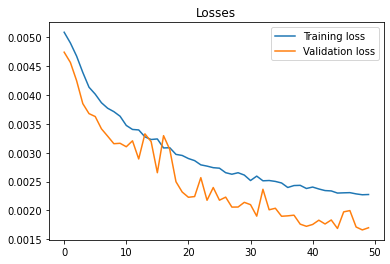

Mean Absolute Error:        4019.951
R^2 Score:                  0.6661048464008499
Adjusted R^2 score          0.6660249663812486
                   value   prediction
date                                 
2010-08-01   1903.716553  1114.789062
2010-08-01   9861.594727  5110.878906
2010-08-01   6448.625488  3550.174316
2010-08-01   1149.090210  1663.608276
2010-08-01   3927.487549  5059.427246
...                  ...          ...
2013-08-01     17.150600    85.753006
2013-08-01     17.150600   908.981750
2013-08-01     17.150600  3567.324707
2013-08-01  20049.050781  8678.203125
2013-08-01     17.150600  -171.506012

[100344 rows x 2 columns]
MAE scores [4597.772, 4019.951]
R2 scores [0.5149244367673464, 0.6661048464008499]
ADJ R2 scores [0.5148083888251063, 0.6660249663812486]
[1/50] Training loss: 0.0051	 Validation loss: 0.0056
[2/50] Training loss: 0.0048	 Validation loss: 0.0051
[3/50] Training loss: 0.0044	 Validation loss: 0.0045
[4/50] Training loss: 0.0041	 Validation loss: 0

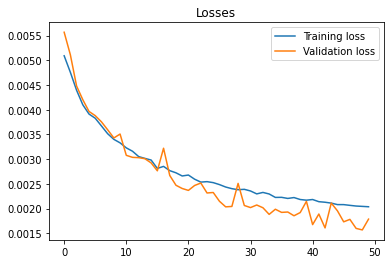

Mean Absolute Error:        4274.6665
R^2 Score:                  0.6894435082707544
Adjusted R^2 score          0.6893692117187403
                   value    prediction
date                                  
2013-08-01  28778.705078  13960.587891
2013-08-01   3018.505615   5042.276367
2013-08-01   4133.294434   1320.596191
2013-08-01      0.000000   1680.758789
2013-08-01     34.301201   1286.294922
...                  ...           ...
2016-08-01    102.903603    960.433594
2016-08-01     17.150600   1286.294922
2016-08-01      0.000000    891.831177
2016-08-01      0.000000    617.421570
2016-08-01      0.000000    428.764984

[100344 rows x 2 columns]
MAE scores [4597.772, 4019.951, 4274.6665]
R2 scores [0.5149244367673464, 0.6661048464008499, 0.6894435082707544]
ADJ R2 scores [0.5148083888251063, 0.6660249663812486, 0.6893692117187403]
[1/50] Training loss: 0.0051	 Validation loss: 0.0063
[2/50] Training loss: 0.0047	 Validation loss: 0.0054
[3/50] Training loss: 0.0042	 Validat

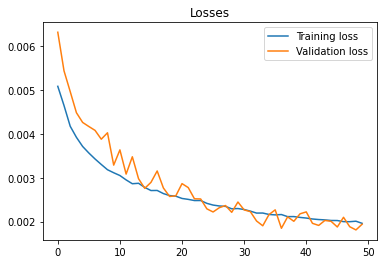

Mean Absolute Error:        4175.8643
R^2 Score:                  0.6819961036319269
Adjusted R^2 score          0.6819200253864017
                  value    prediction
date                                 
2016-08-01     0.000000     68.602402
2016-08-01     0.000000   1046.186523
2016-08-01   480.216797   8197.987305
2016-08-01   171.506012    686.024048
2016-08-01   411.614410    394.463806
...                 ...           ...
2019-08-01    17.150600    445.915588
2019-08-01   754.626404   2641.192383
2019-08-01   154.355392    205.807205
2019-08-01  1372.048096  10187.456055
2019-08-01  5796.902344   3653.077637

[100344 rows x 2 columns]
MAE scores [4597.772, 4019.951, 4274.6665, 4175.8643]
R2 scores [0.5149244367673464, 0.6661048464008499, 0.6894435082707544, 0.6819961036319269]
ADJ R2 scores [0.5148083888251063, 0.6660249663812486, 0.6893692117187403, 0.6819200253864017]
Min MAE score 4019.950927734375
Max R2 score 0.6894435082707544
Max adjusted R2 score 0.6893692117187403


In [ ]:
test_data_ratio = 0.2

#cross validation call
tscv_split = TimeSeriesSplit(max_train_size=None, n_splits= 4)

X = summer_df.drop(columns=['passengers count','origin_city','dest_city'])
y = summer_df[['passengers count']]
val_ratio = test_data_ratio / (1 - test_data_ratio)


output = 1
hidden = 64
layer = 3
batch_size = 64
dropout = 0.2
n_epochs = 50
learning_rate = 1e-3
weight_decay = 1e-6

mae_list = []
r2_score_list = []
adj_r2_score_list = []

for train_index_value, test_index_value in tscv_split.split(X):
  #print("TRAIN:", train_index_value, "TEST:", test_index_value) 
  X_train, X_test = X.iloc[train_index_value], X.iloc[test_index_value]
  y_train, y_test = y.iloc[train_index_value], y.iloc[test_index_value]
  val_ratio = test_data_ratio / (1 - test_data_ratio)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
  #print("X_train",X_train,"x_val",X_val)
  master_train_loader, master_val_loader, master_test_loader, master_test_loader_one, scaler = initialise_data(X_train, X_val, X_test, y_train, y_val,y_test)

  input= get_input_shape(X_train)
  model_parameters = {'input': input,
                'hidden' : hidden,
                'layer' : layer,
                'output' : output,
                'dropout' : dropout}

  summer_model = get_lstm_model('lstm', model_parameters)
  loss_function = nn.MSELoss(reduction="mean")
  optimizer = optim.Adam(summer_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  opt = Opt_model(model=summer_model, loss_function=loss_function, optimizer=optimizer)

  opt.train(master_train_loader, master_val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input)
  opt.plot_losses()

  predictions, values = opt.evaluate(
      master_test_loader_one,
      batch_size=1,
      n_features=input
  )

  df_result = create_results(predictions, values, X_test, scaler)
  #predictions_df = pd.concat([predictions_df, df_result], axis=0)
  scores = get_score(df_result, X_test)  
  print(df_result)
  
  mae_list.append(scores.get('mae'))
  r2_score_list.append(scores.get('r2'))
  adj_r2_score_list.append(scores.get('adjusted r2 score'))
  print('MAE scores' , mae_list)
  print('R2 scores' , r2_score_list)
  print('ADJ R2 scores' ,adj_r2_score_list)
  
mae_min = min(mae_list)
max_r2_score = max(r2_score_list)
max_adj_r2 = max(adj_r2_score_list)

print("Min MAE score {}".format(mae_min))
print("Max R2 score {}".format(max_r2_score))
print("Max adjusted R2 score {}".format(max_adj_r2))



In [ ]:
#creating csvs for train and test results for visualisation
train_set = pd.concat([y_train, y_val], axis=0)
train_set.to_csv('results/dsummer_4splits_train.csv')
df_result.to_csv('results/dsummer_4splits_test.csv')
df_grouped_result = df_result.groupby('date').sum()
train_grouped_set = train_set.groupby('date').sum()


## Autumn

In [ ]:
autumn_df = pd.read_csv('intermittent-result/Domestic US/dom_autumn.csv')
autumn_df.drop(columns = 'Unnamed: 0', inplace= True)

autumn_df.sort_values(['year','month_num'],inplace=True)
autumn_df['date'] = pd.to_datetime(autumn_df.year.astype(str) + '/' + autumn_df.month_num.astype(str) + '/01')

autumn_df = autumn_df.set_index(['date'])
autumn_df.index = pd.to_datetime(autumn_df.index)

In [ ]:
autumn_df.drop(columns = ['year','month','month_num'],inplace= True)

In [ ]:
autumn_df.head()

,origin_city,dest_city,passengers count
date,,,
2005-09-01,47-mile mine,aniak,13.0
2005-09-01,aberdeen,minneapolis,2116.0
2005-09-01,aberdeen,peoria,4.0
2005-09-01,aberdeen,pierre,15.0
2005-09-01,aberdeen,sioux falls,0.0


In [ ]:
autumn_df.shape

(494530, 3)

### Feature Encoding

In [ ]:
#encoding origin city data
org_data = autumn_df['origin_city']
encoder= ce.BinaryEncoder(cols=['origin_city'],return_df=True)
print(encoder)
data_encoded=encoder.fit_transform(org_data) 
data_encoded

BinaryEncoder(cols=['origin_city'], drop_invariant=False,
              handle_missing='value', handle_unknown='value', mapping=None,
              return_df=True, verbose=0)


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,origin_city_0,origin_city_1,origin_city_2,origin_city_3,origin_city_4,origin_city_5,origin_city_6,origin_city_7,origin_city_8,origin_city_9,origin_city_10,origin_city_11
date,,,,,,,,,,,,
2005-09-01,0,0,0,0,0,0,0,0,0,0,0,1
2005-09-01,0,0,0,0,0,0,0,0,0,0,1,0
2005-09-01,0,0,0,0,0,0,0,0,0,0,1,0
2005-09-01,0,0,0,0,0,0,0,0,0,0,1,0
2005-09-01,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-01,0,0,1,1,0,0,1,0,1,0,1,0
2019-11-01,0,0,1,1,0,0,1,0,1,0,1,0
2019-11-01,0,0,1,1,0,0,1,0,1,0,1,0


In [ ]:
#encoding destination city data
dest_data = autumn_df['dest_city']
encoder1= ce.BinaryEncoder(cols=['dest_city'],return_df=True)
print(encoder1)
data_encoded1=encoder1.fit_transform(dest_data) 
data_encoded1

BinaryEncoder(cols=['dest_city'], drop_invariant=False, handle_missing='value',
              handle_unknown='value', mapping=None, return_df=True, verbose=0)


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,dest_city_0,dest_city_1,dest_city_2,dest_city_3,dest_city_4,dest_city_5,dest_city_6,dest_city_7,dest_city_8,dest_city_9,dest_city_10,dest_city_11
date,,,,,,,,,,,,
2005-09-01,0,0,0,0,0,0,0,0,0,0,0,1
2005-09-01,0,0,0,0,0,0,0,0,0,0,1,0
2005-09-01,0,0,0,0,0,0,0,0,0,0,1,1
2005-09-01,0,0,0,0,0,0,0,0,0,1,0,0
2005-09-01,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-01,0,0,0,0,0,0,0,0,0,1,1,0
2019-11-01,0,0,0,0,0,1,0,0,0,0,0,1
2019-11-01,0,0,0,1,0,1,0,0,0,1,0,1


In [ ]:
#combining above two dataframes
df = pd.concat([data_encoded, data_encoded1], axis=1)
autumn_df = pd.concat([autumn_df, df], axis=1)
autumn_df

,origin_city,dest_city,passengers count,origin_city_0,origin_city_1,origin_city_2,origin_city_3,origin_city_4,origin_city_5,origin_city_6,origin_city_7,origin_city_8,origin_city_9,origin_city_10,origin_city_11,dest_city_0,dest_city_1,dest_city_2,dest_city_3,dest_city_4,dest_city_5,dest_city_6,dest_city_7,dest_city_8,dest_city_9,dest_city_10,dest_city_11,origin_city_0,origin_city_1,origin_city_2,origin_city_3,origin_city_4,origin_city_5,origin_city_6,origin_city_7,origin_city_8,origin_city_9,origin_city_10,origin_city_11,dest_city_0,dest_city_1,dest_city_2,dest_city_3,dest_city_4,dest_city_5,dest_city_6,dest_city_7,dest_city_8,dest_city_9,dest_city_10,dest_city_11
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-09-01,47-mile mine,aniak,13.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2005-09-01,aberdeen,minneapolis,2116.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2005-09-01,aberdeen,peoria,4.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1
2005-09-01,aberdeen,pierre,15.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2005-09-01,aberdeen,sioux falls,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-01,yuma,dallas/fort worth,1597.0,0,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
2019-11-01,yuma,farmington,0.0,0,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
2019-11-01,yuma,laredo,0.0,0,0,1,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1


### LSTM

[1/50] Training loss: 0.0061	 Validation loss: 0.0064
[2/50] Training loss: 0.0058	 Validation loss: 0.0060
[3/50] Training loss: 0.0055	 Validation loss: 0.0053
[4/50] Training loss: 0.0052	 Validation loss: 0.0050
[5/50] Training loss: 0.0050	 Validation loss: 0.0047
[6/50] Training loss: 0.0048	 Validation loss: 0.0046
[7/50] Training loss: 0.0046	 Validation loss: 0.0044
[8/50] Training loss: 0.0044	 Validation loss: 0.0043
[9/50] Training loss: 0.0043	 Validation loss: 0.0039
[10/50] Training loss: 0.0041	 Validation loss: 0.0039
[11/50] Training loss: 0.0040	 Validation loss: 0.0036
[12/50] Training loss: 0.0037	 Validation loss: 0.0034
[13/50] Training loss: 0.0037	 Validation loss: 0.0033
[14/50] Training loss: 0.0037	 Validation loss: 0.0039
[15/50] Training loss: 0.0037	 Validation loss: 0.0033
[16/50] Training loss: 0.0035	 Validation loss: 0.0032
[17/50] Training loss: 0.0035	 Validation loss: 0.0037
[18/50] Training loss: 0.0035	 Validation loss: 0.0030
[19/50] Training lo

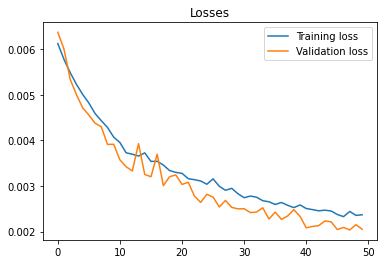

Mean Absolute Error:        3148.3381
R^2 Score:                  0.6850308130760001
Adjusted R^2 score          0.684877879839382
                 value   prediction
date                               
2007-11-01    0.000000   520.826782
2007-11-01  225.222397   394.139191
2007-11-01  295.604401  -365.986389
2007-11-01   98.534798  1097.959229
2007-11-01   14.076400    56.305599
...                ...          ...
2010-11-01   14.076400   548.979614
2010-11-01   14.076400  1168.341187
2010-11-01    0.000000  1590.633301
2010-11-01    0.000000   760.125610
2010-11-01    0.000000   971.271606

[98906 rows x 2 columns]
MAE scores [3148.3381]
R2 scores [0.6850308130760001]
ADJ R2 scores [0.684877879839382]
[1/50] Training loss: 0.0052	 Validation loss: 0.0050
[2/50] Training loss: 0.0047	 Validation loss: 0.0044
[3/50] Training loss: 0.0043	 Validation loss: 0.0041
[4/50] Training loss: 0.0040	 Validation loss: 0.0036
[5/50] Training loss: 0.0037	 Validation loss: 0.0032
[6/50] Training l

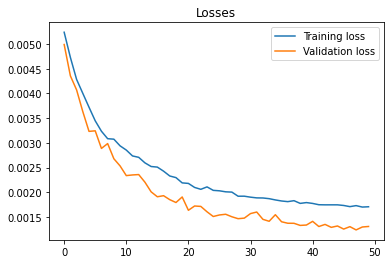

Mean Absolute Error:        2830.7197
R^2 Score:                  0.7718968847831337
Adjusted R^2 score          0.7717861293532662
                value   prediction
date                              
2010-11-01  29.723799  -341.823700
2010-11-01  59.447598  1679.394775
2010-11-01   0.000000   -74.309502
2010-11-01   0.000000   148.619003
2010-11-01   0.000000   193.204697
...               ...          ...
2013-11-01   0.000000   -44.585701
2013-11-01  29.723799   -74.309502
2013-11-01  14.861899  -178.342804
2013-11-01   0.000000   -44.585701
2013-11-01   0.000000    14.861899

[98906 rows x 2 columns]
MAE scores [3148.3381, 2830.7197]
R2 scores [0.6850308130760001, 0.7718968847831337]
ADJ R2 scores [0.684877879839382, 0.7717861293532662]
[1/50] Training loss: 0.0044	 Validation loss: 0.0043
[2/50] Training loss: 0.0038	 Validation loss: 0.0038
[3/50] Training loss: 0.0034	 Validation loss: 0.0033
[4/50] Training loss: 0.0030	 Validation loss: 0.0028
[5/50] Training loss: 0.0028	 Va

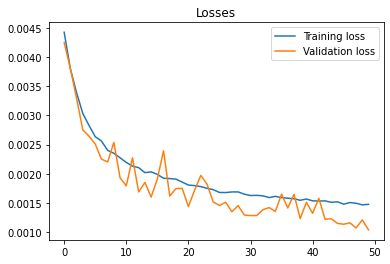

Mean Absolute Error:        3351.4172
R^2 Score:                  0.7943692160449004
Adjusted R^2 score          0.7942693720517604
                  value   prediction
date                                
2013-11-01    16.077600   900.345581
2013-11-01     0.000000   659.181580
2013-11-01   192.931213  1125.432007
2013-11-01  3006.511230  7749.403320
2013-11-01   771.724854  4099.788086
...                 ...          ...
2016-11-01   128.620804  1302.285645
2016-11-01     0.000000   916.423218
2016-11-01     0.000000  1109.354370
2016-11-01     0.000000  2218.708740
2016-11-01     0.000000  1623.837524

[98906 rows x 2 columns]
MAE scores [3148.3381, 2830.7197, 3351.4172]
R2 scores [0.6850308130760001, 0.7718968847831337, 0.7943692160449004]
ADJ R2 scores [0.684877879839382, 0.7717861293532662, 0.7942693720517604]
[1/50] Training loss: 0.0044	 Validation loss: 0.0051
[2/50] Training loss: 0.0036	 Validation loss: 0.0043
[3/50] Training loss: 0.0032	 Validation loss: 0.0033
[4/50] Tr

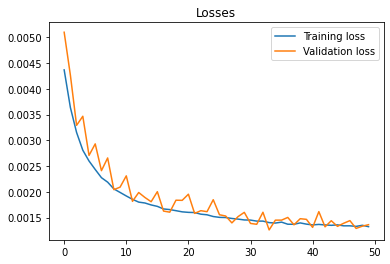

Mean Absolute Error:        3386.6357
R^2 Score:                  0.7588165221220131
Adjusted R^2 score          0.7586994155242188
                  value   prediction
date                                
2016-11-01     0.000000  -163.029007
2016-11-01     0.000000   831.447937
2016-11-01     0.000000  -521.692810
2016-11-01    16.302900   -48.908703
2016-11-01  5021.292969  4173.542480
...                 ...          ...
2019-11-01  1597.684204  4026.816406
2019-11-01     0.000000   -16.302900
2019-11-01     0.000000   -81.514503
2019-11-01  7075.458496  1613.987061
2019-11-01     0.000000    97.817406

[98906 rows x 2 columns]
MAE scores [3148.3381, 2830.7197, 3351.4172, 3386.6357]
R2 scores [0.6850308130760001, 0.7718968847831337, 0.7943692160449004, 0.7588165221220131]
ADJ R2 scores [0.684877879839382, 0.7717861293532662, 0.7942693720517604, 0.7586994155242188]
Min MAE score 2830.7197265625
Max R2 score 0.7943692160449004
Max adjusted R2 score 0.7942693720517604


In [ ]:
test_data_ratio = 0.2
#cross validation call
tscv_split = TimeSeriesSplit(max_train_size=None, n_splits= 4)

X = autumn_df.drop(columns=['passengers count','origin_city','dest_city'])
y = autumn_df[['passengers count']]
val_ratio = test_data_ratio / (1 - test_data_ratio)


output = 1
hidden = 64
layer = 3
batch_size = 64
dropout = 0.2
n_epochs = 50
learning_rate = 1e-3
weight_decay = 1e-6

mae_list = []
r2_score_list = []
adj_r2_score_list = []

for train_index_value, test_index_value in tscv_split.split(X):
  #print("TRAIN:", train_index_value, "TEST:", test_index_value) 
  X_train, X_test = X.iloc[train_index_value], X.iloc[test_index_value]
  y_train, y_test = y.iloc[train_index_value], y.iloc[test_index_value]
  val_ratio = test_data_ratio / (1 - test_data_ratio)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
  #print("X_train",X_train,"x_val",X_val)
  master_train_loader, master_val_loader, master_test_loader, master_test_loader_one, scaler = initialise_data(X_train, X_val, X_test, y_train, y_val,y_test)

  input = get_input_shape(X_train)
  model_parameters = {'input': input,
                'hidden' : hidden,
                'layer' : layer,
                'output' : output,
                'dropout' : dropout}

  autumn_model = get_lstm_model('lstm', model_parameters)
  loss_function = nn.MSELoss(reduction="mean")
  optimizer = optim.Adam(autumn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  opt = Opt_model(model=autumn_model, loss_function=loss_function, optimizer=optimizer)

  opt.train(master_train_loader, master_val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input)
  opt.plot_losses()

  predictions, values = opt.evaluate(
      master_test_loader_one,
      batch_size=1,
      n_features=input
  )

  df_result = create_results(predictions, values, X_test, scaler)
  #predictions_df = pd.concat([predictions_df, df_result], axis=0)
  scores = get_score(df_result, X_test)  
  print(df_result)
  
  mae_list.append(scores.get('mae'))
  r2_score_list.append(scores.get('r2'))
  adj_r2_score_list.append(scores.get('adjusted r2 score'))
  print('MAE scores' , mae_list)
  print('R2 scores' , r2_score_list)
  print('ADJ R2 scores' ,adj_r2_score_list)
  
mae_min = min(mae_list)
max_r2_score = max(r2_score_list)
max_adj_r2 = max(adj_r2_score_list)

print("Min MAE score {}".format(mae_min))
print("Max R2 score {}".format(max_r2_score))
print("Max adjusted R2 score {}".format(max_adj_r2))



In [ ]:
#creating csvs to store the train and test results for visualisation 
train_set = pd.concat([y_train, y_val], axis=0)
train_set.to_csv('results/dautumn_4splits_train.csv')
df_result.to_csv('results/dautumn_4splits_test.csv')
df_grouped_result = df_result.groupby('date').sum()
train_grouped_set = train_set.groupby('date').sum()


## Winter

In [ ]:
winter_df = pd.read_csv('intermittent-result/Domestic US/dom_winter.csv')
winter_df.drop(columns = 'Unnamed: 0', inplace= True)

winter_df.sort_values(['year','month_num'],inplace=True)
winter_df['date'] = pd.to_datetime(winter_df.year.astype(str) + '/' + winter_df.month_num.astype(str) + '/01')

winter_df = winter_df.set_index(['date'])
winter_df.index = pd.to_datetime(winter_df.index)

### Feature Encoding

In [ ]:
#encoding origin city data
org_data = winter_df['origin_city']
encoder= ce.BinaryEncoder(cols=['origin_city'],return_df=True)
print(encoder)
data_encoded=encoder.fit_transform(org_data) 
data_encoded

BinaryEncoder(cols=['origin_city'], drop_invariant=False,
              handle_missing='value', handle_unknown='value', mapping=None,
              return_df=True, verbose=0)


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,origin_city_0,origin_city_1,origin_city_2,origin_city_3,origin_city_4,origin_city_5,origin_city_6,origin_city_7,origin_city_8,origin_city_9,origin_city_10,origin_city_11
date,,,,,,,,,,,,
2005-01-01,0,0,0,0,0,0,0,0,0,0,0,1
2005-01-01,0,0,0,0,0,0,0,0,0,0,0,1
2005-01-01,0,0,0,0,0,0,0,0,0,0,0,1
2005-01-01,0,0,0,0,0,0,0,0,0,0,1,0
2005-01-01,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-01,0,0,1,0,1,1,1,1,0,0,0,0
2019-12-01,0,0,1,0,1,1,1,1,0,0,0,0
2019-12-01,0,0,1,0,1,1,1,1,0,0,0,0


In [ ]:
#encoding destination city data
dest_data = winter_df['dest_city']
encoder1= ce.BinaryEncoder(cols=['dest_city'],return_df=True)
print(encoder1)
data_encoded1=encoder1.fit_transform(dest_data) 
data_encoded1

BinaryEncoder(cols=['dest_city'], drop_invariant=False, handle_missing='value',
              handle_unknown='value', mapping=None, return_df=True, verbose=0)


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,dest_city_0,dest_city_1,dest_city_2,dest_city_3,dest_city_4,dest_city_5,dest_city_6,dest_city_7,dest_city_8,dest_city_9,dest_city_10,dest_city_11
date,,,,,,,,,,,,
2005-01-01,0,0,0,0,0,0,0,0,0,0,0,1
2005-01-01,0,0,0,0,0,0,0,0,0,0,1,0
2005-01-01,0,0,0,0,0,0,0,0,0,0,1,1
2005-01-01,0,0,0,0,0,0,0,0,0,1,0,0
2005-01-01,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-01,0,0,0,1,0,0,0,0,0,0,1,1
2019-12-01,0,0,0,0,0,0,0,0,0,1,0,1
2019-12-01,0,1,0,0,0,1,0,1,1,1,0,1


In [ ]:
#merging above two dataframes
df = pd.concat([data_encoded, data_encoded1], axis=1)
winter_df = pd.concat([winter_df, df], axis=1)
winter_df

,year,month,origin_city,dest_city,month_num,passengers count,origin_city_0,origin_city_1,origin_city_2,origin_city_3,origin_city_4,origin_city_5,origin_city_6,origin_city_7,origin_city_8,origin_city_9,origin_city_10,origin_city_11,dest_city_0,dest_city_1,dest_city_2,dest_city_3,dest_city_4,dest_city_5,dest_city_6,dest_city_7,dest_city_8,dest_city_9,dest_city_10,dest_city_11
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-01-01,2005,january,aberdeen,minneapolis,1,2374.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2005-01-01,2005,january,aberdeen,pierre,1,17.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2005-01-01,2005,january,aberdeen,sioux falls,1,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
2005-01-01,2005,january,abilene,beaumont/port arthur,1,3.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2005-01-01,2005,january,abilene,dallas/fort worth,1,3848.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-01,2019,december,yuma,alexandria,12,55.0,0,0,1,0,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
2019-12-01,2019,december,yuma,dallas/fort worth,12,2575.0,0,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2019-12-01,2019,december,yuma,hawthorne,12,9.0,0,0,1,0,1,1,1,1,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,1


### LSTM

[1/50] Training loss: 0.0040	 Validation loss: 0.0040
[2/50] Training loss: 0.0039	 Validation loss: 0.0039
[3/50] Training loss: 0.0038	 Validation loss: 0.0038
[4/50] Training loss: 0.0037	 Validation loss: 0.0037
[5/50] Training loss: 0.0037	 Validation loss: 0.0035
[6/50] Training loss: 0.0035	 Validation loss: 0.0034
[7/50] Training loss: 0.0034	 Validation loss: 0.0033
[8/50] Training loss: 0.0033	 Validation loss: 0.0032
[9/50] Training loss: 0.0033	 Validation loss: 0.0031
[10/50] Training loss: 0.0032	 Validation loss: 0.0030
[11/50] Training loss: 0.0032	 Validation loss: 0.0031
[12/50] Training loss: 0.0032	 Validation loss: 0.0029
[13/50] Training loss: 0.0031	 Validation loss: 0.0029
[14/50] Training loss: 0.0031	 Validation loss: 0.0029
[15/50] Training loss: 0.0030	 Validation loss: 0.0028
[16/50] Training loss: 0.0030	 Validation loss: 0.0028
[17/50] Training loss: 0.0030	 Validation loss: 0.0028
[18/50] Training loss: 0.0030	 Validation loss: 0.0026
[19/50] Training lo

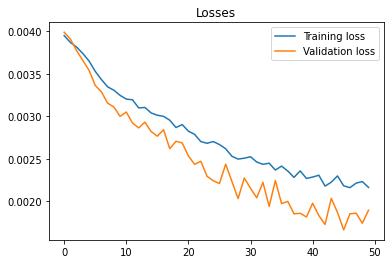

Mean Absolute Error:        3613.9446
R^2 Score:                  0.48507531784322877
Adjusted R^2 score          0.48494465548300547
                   value    prediction
date                                  
2007-12-01   8462.641602   4611.379395
2007-12-01   1114.838989   3327.625488
2007-12-01      0.000000   2212.786621
2007-12-01   2060.762939   -675.660034
2007-12-01   2787.097412  11992.965820
...                  ...           ...
2010-12-01  11790.266602   2212.786621
2010-12-01  33377.605469  12465.926758
2010-12-01   1013.489990  -1216.187988
2010-12-01    236.480988  -1233.079590
2010-12-01  12144.989258   5658.652832

[98548 rows x 2 columns]
MAE scores [3613.9446]
R2 scores [0.48507531784322877]
ADJ R2 scores [0.48494465548300547]
[1/50] Training loss: 0.0038	 Validation loss: 0.0033
[2/50] Training loss: 0.0037	 Validation loss: 0.0032
[3/50] Training loss: 0.0036	 Validation loss: 0.0030
[4/50] Training loss: 0.0034	 Validation loss: 0.0029
[5/50] Training loss: 0.00

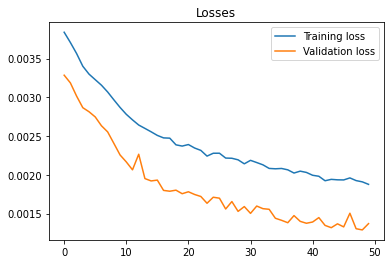

Mean Absolute Error:        3608.4248
R^2 Score:                  0.5975824234895935
Adjusted R^2 score          0.5974803098559607
                  value   prediction
date                                
2010-12-01  6300.529785  2651.965332
2010-12-01  4797.186035  4442.464355
2010-12-01    16.891500   -84.457504
2010-12-01  3158.710449  1756.716064
2010-12-01  4121.525879  1013.489990
...                 ...          ...
2013-12-01     0.000000  -405.396027
2013-12-01  9442.348633  1858.064941
2013-12-01  4020.177002  1942.522461
2013-12-01    16.891500  1216.187988
2013-12-01     0.000000  1216.187988

[98548 rows x 2 columns]
MAE scores [3613.9446, 3608.4248]
R2 scores [0.48507531784322877, 0.5975824234895935]
ADJ R2 scores [0.48494465548300547, 0.5974803098559607]
[1/50] Training loss: 0.0037	 Validation loss: 0.0044
[2/50] Training loss: 0.0035	 Validation loss: 0.0039
[3/50] Training loss: 0.0033	 Validation loss: 0.0035
[4/50] Training loss: 0.0031	 Validation loss: 0.0032
[5/

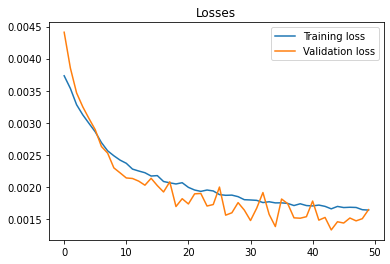

Mean Absolute Error:        3753.7703
R^2 Score:                  0.5943733252144244
Adjusted R^2 score          0.5942703972707201
                   value    prediction
date                                  
2013-12-01    118.240494   -506.744995
2013-12-01   3175.602051   2364.810059
2013-12-01   2922.229492    118.240494
2013-12-01      0.000000   -405.396027
2013-12-01      0.000000   -354.721497
...                  ...           ...
2016-12-01   2432.375977    574.311035
2016-12-01   5810.676270   4814.077637
2016-12-01   4560.705078   4966.101074
2016-12-01   1706.041382   3597.889404
2016-12-01  21181.941406  21756.251953

[98548 rows x 2 columns]
MAE scores [3613.9446, 3608.4248, 3753.7703]
R2 scores [0.48507531784322877, 0.5975824234895935, 0.5943733252144244]
ADJ R2 scores [0.48494465548300547, 0.5974803098559607, 0.5942703972707201]
[1/50] Training loss: 0.0038	 Validation loss: 0.0049
[2/50] Training loss: 0.0035	 Validation loss: 0.0043
[3/50] Training loss: 0.0032	 Vali

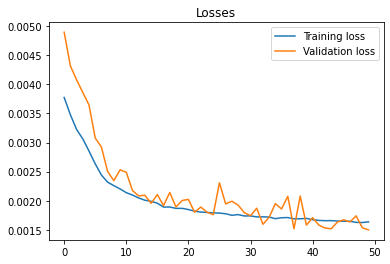

Mean Absolute Error:        4263.3545
R^2 Score:                  0.6812354578876002
Adjusted R^2 score          0.6811545712475319
                   value    prediction
date                                  
2016-12-01    844.574951   1756.716064
2016-12-01     16.891500   3851.261963
2016-12-01  29712.148438  11976.073242
2016-12-01   1993.197021   3749.912842
2016-12-01   6553.902344   4138.417480
...                  ...           ...
2019-12-01     50.674503   2128.329102
2019-12-01   2567.508057   9712.612305
2019-12-01     16.891500   3175.602051
2019-12-01   7246.453613  12465.926758
2019-12-01     16.891500   2449.267334

[98548 rows x 2 columns]
MAE scores [3613.9446, 3608.4248, 3753.7703, 4263.3545]
R2 scores [0.48507531784322877, 0.5975824234895935, 0.5943733252144244, 0.6812354578876002]
ADJ R2 scores [0.48494465548300547, 0.5974803098559607, 0.5942703972707201, 0.6811545712475319]
Min MAE score 3608.4248046875
Max R2 score 0.6812354578876002
Max adjusted R2 score 0.68115

In [ ]:
test_data_ratio = 0.2

#cross validation call
tscv_split = TimeSeriesSplit(max_train_size=None, n_splits= 4)

X = winter_df.drop(columns=['passengers count','origin_city','dest_city','year','month'])
y = winter_df[['passengers count']]
val_ratio = test_data_ratio / (1 - test_data_ratio)


output = 1
hidden = 64
layer = 3
batch_size = 64
dropout = 0.2
n_epochs = 50
learning_rate = 1e-3
weight_decay = 1e-6

mae_list = []
r2_score_list = []
adj_r2_score_list = []

for train_index_value, test_index_value in tscv_split.split(X):
  #print("TRAIN:", train_index_value, "TEST:", test_index_value) 
  X_train, X_test = X.iloc[train_index_value], X.iloc[test_index_value]
  y_train, y_test = y.iloc[train_index_value], y.iloc[test_index_value]
  val_ratio = test_data_ratio / (1 - test_data_ratio)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
  #print("X_train",X_train,"x_val",X_val)
  master_train_loader, master_val_loader, master_test_loader, master_test_loader_one, scaler = initialise_data(X_train, X_val, X_test, y_train, y_val,y_test)

  input = get_input_shape(X_train)
  model_parameters = {'input': input,
                'hidden' : hidden,
                'layer' : layer,
                'output' : output,
                'dropout' : dropout}

  winter_model = get_lstm_model('lstm', model_parameters)
  loss_function = nn.MSELoss(reduction="mean")
  optimizer = optim.Adam(winter_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  opt = Opt_model(model=winter_model, loss_function=loss_function, optimizer=optimizer)

  opt.train(master_train_loader, master_val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input)
  opt.plot_losses()

  predictions, values = opt.evaluate(
      master_test_loader_one,
      batch_size=1,
      n_features=input
  )

  df_result = create_results(predictions, values, X_test, scaler)
  #predictions_df = pd.concat([predictions_df, df_result], axis=0)
  scores = get_score(df_result, X_test)  
  print(df_result)
  
  mae_list.append(scores.get('mae'))
  r2_score_list.append(scores.get('r2'))
  adj_r2_score_list.append(scores.get('adjusted r2 score'))
  print('MAE scores' , mae_list)
  print('R2 scores' , r2_score_list)
  print('ADJ R2 scores' ,adj_r2_score_list)
  
mae_min = min(mae_list)
max_r2_score = max(r2_score_list)
max_adj_r2 = max(adj_r2_score_list)

print("Min MAE score {}".format(mae_min))
print("Max R2 score {}".format(max_r2_score))
print("Max adjusted R2 score {}".format(max_adj_r2))



In [ ]:
#creating csvs to store the train and test results for visualisation
train_set = pd.concat([y_train, y_val], axis=0)
train_set.to_csv('results/dwinter_4splits_train.csv')
df_result.to_csv('results/dwinter_4splits_test.csv')
df_grouped_result = df_result.groupby('date').sum()
train_grouped_set = train_set.groupby('date').sum()
